In [1]:
import pandas as pd
from pandas import datetime
#import datetime
import matplotlib
import numpy as np
#import warnings
#import itertools
#import statsmodels.api as sm
from pandas import Series
from pandas import datetime
from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
#plt.style.use('fivethirtyeight')
%matplotlib inline
 
production=pd.read_pickle("./processed/production_all_dates_and_variables.pkl")
keep_these=['Wind_KWH',
            'Solar_KWH',
            'Wind_Speed_AT_WINDFARM',
            'Solar_Elevation',
            'Cloud_Cover_Fraction',
            'Dew_Point',
            'Humidity_Fraction',
            'Precipitation',
            'Pressure',
            'Temperature',
            'Visibility',
            'Wind_Speed_AT_SOLARRAY']
production=production[keep_these]
#fill the date and time gaps
production = production.resample("60min").asfreq()
print(production.head(25))


                     Wind_KWH  Solar_KWH  Wind_Speed_AT_WINDFARM  \
Time                                                               
2010-01-04 15:00:00       NaN   14186.16                     NaN   
2010-01-04 16:00:00       NaN    5898.00                     NaN   
2010-01-04 17:00:00       NaN        NaN                     NaN   
2010-01-04 18:00:00       NaN        NaN                     NaN   
2010-01-04 19:00:00       NaN        NaN                     NaN   
2010-01-04 20:00:00       NaN        NaN                     NaN   
2010-01-04 21:00:00       NaN        NaN                     NaN   
2010-01-04 22:00:00       NaN        NaN                     NaN   
2010-01-04 23:00:00       NaN        NaN                     NaN   
2010-01-05 00:00:00       NaN        NaN                     NaN   
2010-01-05 01:00:00       NaN        NaN                     NaN   
2010-01-05 02:00:00       NaN        NaN                     NaN   
2010-01-05 03:00:00       NaN        NaN        

In [2]:
"""
Implement an imputation scheme for each variable.

Dependent Variables - no imputation
solar - if nighttime, zero
=========================================
'Temperature', - Average
'Visibility', - Average
'Wind_Speed_AT_SOLARRAY' - Average

""" 

solar_prod=production['Solar_KWH']
solar_prod_by_hour = solar_prod.resample("60min").sum().to_frame('Solar_KWH')
solar_prod_by_hour.to_pickle("./processed/solar_prod_by_hour.pkl")

independent_vars=['Temperature',
                  'Visibility',
                  'Wind_Speed_AT_SOLARRAY']

indep_vars=production[independent_vars]
for field in independent_vars:
    tmp=pd.DataFrame(data=indep_vars[field])
    tmp.dropna(axis=0, inplace=True)
    tmp=tmp.loc[tmp[field]!='nan'] 
    tmp=pd.to_numeric(tmp[field], downcast='float')
    solar_prod_by_hour=solar_prod_by_hour.join(tmp, how='left', sort=True)
    
# Now, we need to interpolate missing values.

def interpolate_gaps(values, limit=None):
    """
    Fill gaps using linear interpolation, optionally only fill gaps up to a
    size of `limit`, courtesy of StackOVerflow:
    https://stackoverflow.com/questions/36455083/working-with-nan-values-in-matplotlib
    """
    values = np.asarray(values)
    i = np.arange(values.size)
    valid = np.isfinite(values)
    filled = np.interp(i, i[valid], values[valid])

    if limit is not None:
        invalid = ~valid
        for n in range(1, limit+1):
            invalid[:-n] &= invalid[n:]
        filled[invalid] = np.nan
    return filled


columns={}
dates=solar_prod_by_hour.index.values
columns['Date']=dates
for field in list(solar_prod_by_hour):
    raw=solar_prod_by_hour[field].values
    filled = interpolate_gaps(raw, limit=2)
    columns[field]=filled

solar_prod_by_hour_fnl=pd.DataFrame.from_dict(columns)
solar_prod_by_hour_fnl.set_index('Date', inplace=True)
solar_prod_by_hour_fnl=solar_prod_by_hour_fnl.fillna(0)
solar_prod_by_hour_fnl.to_pickle("./processed/solar_prod_by_hour_w_interpolation.pkl")
print(solar_prod_by_hour_fnl.head(25))

                     Solar_KWH  Temperature  Visibility  \
Date                                                      
2010-01-04 15:00:00   14186.16    -3.900000   16.093000   
2010-01-04 16:00:00    5898.00    -3.300000   16.093000   
2010-01-04 17:00:00       0.00     0.000000    0.000000   
2010-01-04 18:00:00       0.00     0.000000    0.000000   
2010-01-04 19:00:00       0.00     0.000000    0.000000   
2010-01-04 20:00:00       0.00     0.000000    0.000000   
2010-01-04 21:00:00       0.00     0.000000    0.000000   
2010-01-04 22:00:00       0.00     0.000000    0.000000   
2010-01-04 23:00:00       0.00     0.000000    0.000000   
2010-01-05 00:00:00       0.00     0.000000    0.000000   
2010-01-05 01:00:00       0.00     0.000000    0.000000   
2010-01-05 02:00:00       0.00     0.000000    0.000000   
2010-01-05 03:00:00       0.00     0.000000    0.000000   
2010-01-05 04:00:00       0.00     0.000000    0.000000   
2010-01-05 05:00:00       0.00     0.000000    0.000000 

In [3]:
solar_prod=solar_prod_by_hour_fnl
#solar_prod['Month']=solar_prod.index.month
#solar_prod['Day']=solar_prod.index.day
solar_prod['Hour']=solar_prod.index.hour
print(solar_prod.head())

                     Solar_KWH  Temperature  Visibility  \
Date                                                      
2010-01-04 15:00:00   14186.16         -3.9      16.093   
2010-01-04 16:00:00    5898.00         -3.3      16.093   
2010-01-04 17:00:00       0.00          0.0       0.000   
2010-01-04 18:00:00       0.00          0.0       0.000   
2010-01-04 19:00:00       0.00          0.0       0.000   

                     Wind_Speed_AT_SOLARRAY  Hour  
Date                                               
2010-01-04 15:00:00                     5.7    15  
2010-01-04 16:00:00                     3.6    16  
2010-01-04 17:00:00                     0.0    17  
2010-01-04 18:00:00                     0.0    18  
2010-01-04 19:00:00                     0.0    19  


In [4]:
# Trying the approach of letting the model learn about time.
corr=solar_prod.corr()
corr.style.background_gradient().set_precision(2)

,Solar_KWH,Temperature,Visibility,Wind_Speed_AT_SOLARRAY,Hour
Solar_KWH,1,0.36,0.42,0.32,0.14
Temperature,0.36,1,0.48,0.25,0.12
Visibility,0.42,0.48,1,0.59,0.034
Wind_Speed_AT_SOLARRAY,0.32,0.25,0.59,1,0.093
Hour,0.14,0.12,0.034,0.093,1


Mean squared error: 2,023,863,315.7548158
Variance score: 0.22911769063271503


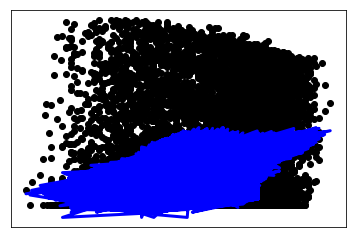

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn import svm

X=solar_prod[['Temperature', 'Visibility','Wind_Speed_AT_SOLARRAY','Hour']].values
y=solar_prod['Solar_KWH'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    random_state=9)

regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

#print('Coefficients: \n', regr.coef_)
print("Mean squared error: {:,}".format(mean_squared_error(y_test, y_pred)))
print('Variance score: {:,}'.format(r2_score(y_test, y_pred)))

#print("x_test: {} y_test: {} y_pred: {}".format(len(X_test), len(y_test), len(y_pred)))
plt.scatter(X_test[:,0], y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())

plt.show()

In [33]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

rng = np.random.RandomState(1)

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                           n_estimators=300,
                           random_state=rng)

regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)

print("Decision Tree Regressor: {:,}".format(mean_squared_error(y, y_1)))
print("Adaboost Regressor: {:,}".format(mean_squared_error(y, y_2)))



Decision Tree Regressor: 877,988,839.9463313
Adaboost Regressor: 812,028,685.5891974
